# CSV/Excel Analysis Agent


## Overview

This tutorial covers how to create an agent that performs analysis on the `Pandas` DataFrame loaded from CSV or Excel files. The agent generates `Pandas` queries to analyze the dataset.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Sample Data](#sample-data)
- [Create an Analysis Agent](#create-an-analysis-agent)

### References
- [LangChain Documentation : create_pandas_dataframe_agent](https://python.langchain.com/api_reference/experimental/agents/langchain_experimental.agents.agent_toolkits.pandas.base.create_pandas_dataframe_agent.html)
----

## Environment Setup


In [1]:
# import getenv
import os
import getpass
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI

In [2]:
# Correctly set environment variables using os.environ
os.environ["AZURE_OPENAI_API_VERSION"] = "2025-01-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://ai-mainhub986025242733.services.ai.azure.com"
os.environ["AZURE_OPENAI_API_KEY"] = "9gLvGnTyAYZBbsmsBZbOWFJkLwe1DBJZFYtFHG3qf4Gf9Gth8jRXJQQJ99BAACfhMk5XJ3w3AAAAACOGzKp1"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = "gpt-4o"
os.environ["TAVILY_API_KEY"] = "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"

## Sample Data

Document Used for Practice : **Titanic Dataset**
- File Name : titanic.csv
- Link : [Stanford CS109 Material](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/)
- Reference : [Titanic - Machine Learning from Disaster (Kaggle)](https://www.kaggle.com/c/titanic/data)

*Please copy the downloaded file to the data folder for practice.*

In [3]:
import pandas as pd

# Load CSV file
df = pd.read_csv("./data/titanic.csv")
# In case of loading an Excel file
# df = pd.read_excel("./data/titanic.xlsx", sheet_name="Sheet1")
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Create an Analysis Agent

Define an agent to analyze the data loaded from CSV or Excel files using `create_pandas_dataframe_agent` . 

This agent needs a `PythonAstREPLTool` to execute Python codes. Also, a custom function is defined to print the intermediate steps of the agent execution.

In [4]:
from langchain_experimental.tools import PythonAstREPLTool

# Create a tool to execute Python codes.
python_tool = PythonAstREPLTool()

# Load the DataFrame on locals["df"]
python_tool.locals["df"] = df

In [ ]:
#%pip install tabulate
#%pip install seaborn


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import AzureChatOpenAI

# Create an agent
agent = create_pandas_dataframe_agent(
    AzureChatOpenAI(model="gpt-4o", temperature=0, api_version="2025-01-01-preview"),
    df,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst. "
    "You must use Pandas DataFrame(`df`) to answer user's queries. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "For visualization of the analyzed result, please use `plt.show()` at the end of your code. "
    "I prefer seaborn for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",  # Add additional instructions to the default prompt
)

In [6]:
from langchain_core.agents import AgentStep


# Define a function to stream intermediate steps of executing the agent.
def stream_response(query):
    response = agent.stream({"input": query})
    for step in response:
        if "actions" in step:
            if step["actions"][0].tool == "python_repl_ast":
                tool_input = step["actions"][0].tool_input
                for k, v in tool_input.items():
                    if k == "query":
                        print(f"---- Code Begins ----")
                        print(v)
                        result = python_tool.invoke({"query": v})
                        print(result)
                        print(f"---- Code Ends ----")
        elif "steps" in step:
            print(f"---- Message Begins ----")
            for observation in step["steps"]:
                if isinstance(observation, AgentStep):
                    print(getattr(observation, "observation", None))
            print(f"---- Message Ends ----")
        elif "output" in step:
            print(f"---- Final Answer Begins ----")
            print(step["output"])
            print(f"---- Final Answer Ends ----")

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='muted', fmt='.2f', cbar=True, square=True, linewidths=0.5)

# Customize the plot aesthetics
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Code Ends ----
---- Message Begins ----
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Message Ends ----
---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.he

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

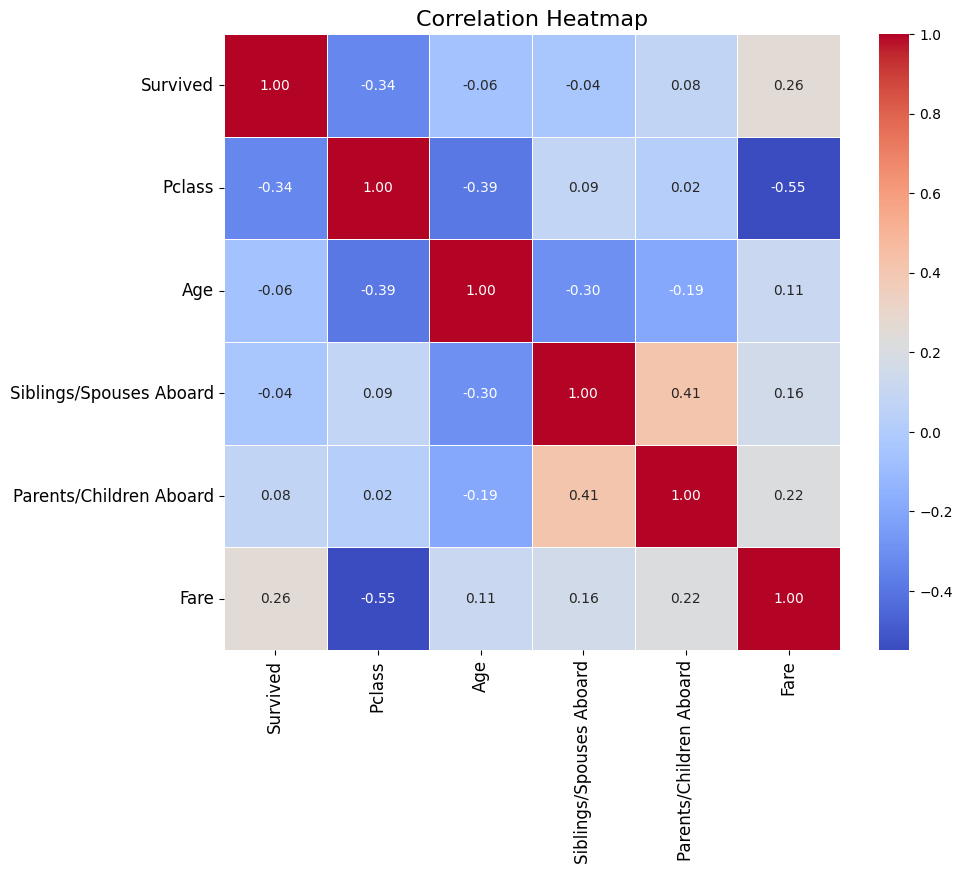

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, linewidths=0.5)

# Customize the plot aesthetics
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

---- Code Ends ----


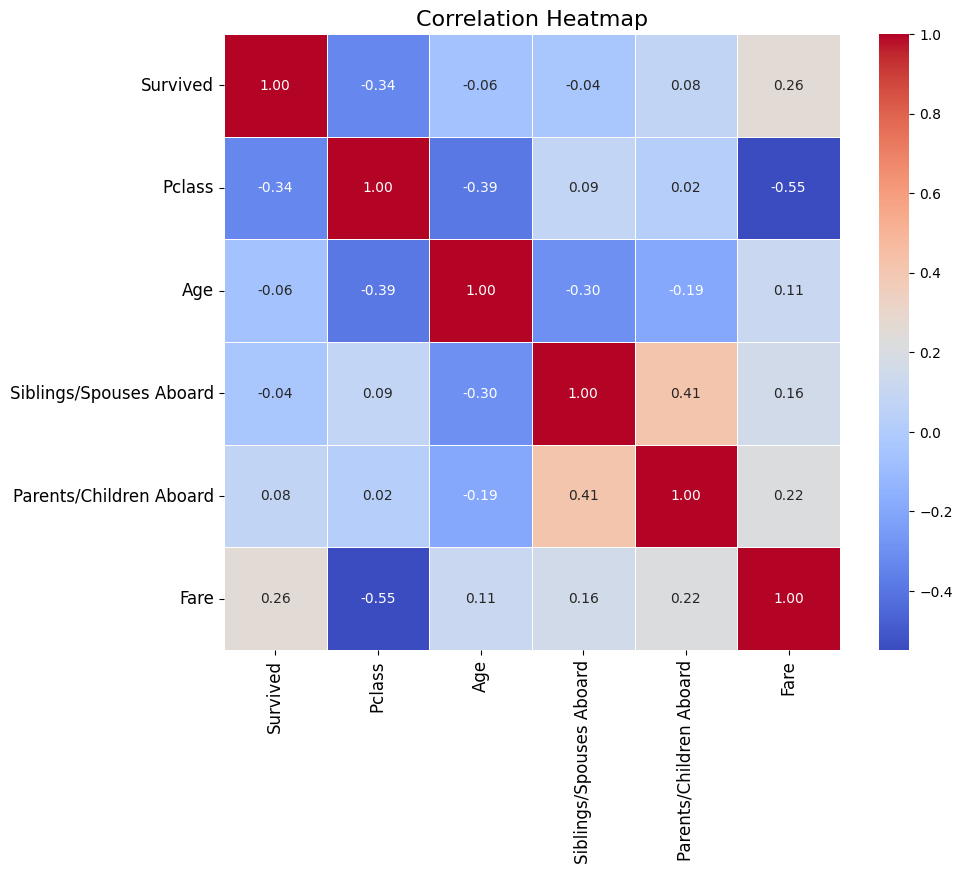

---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The correlation heatmap has been successfully visualized using the `'coolwarm'` colormap. It displays the relationships between numeric features in the dataset. Let me know if you need further analysis or adjustments!
---- Final Answer Ends ----


In [7]:
stream_response("Visualize correlations as a heatmap.")

In [8]:
stream_response("How many rows are there?")

---- Code Begins ----
len(df)
887
---- Code Ends ----
---- Message Begins ----
887
---- Message Ends ----
---- Final Answer Begins ----
The DataFrame contains 887 rows.
---- Final Answer Ends ----


---- Code Begins ----
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate survival rates by gender
survival_rates = df.groupby('Sex')['Survived'].mean()

# Plot the survival rates
sns.set_theme(style="white", palette="muted")
plt.figure(figsize=(8, 6))
sns.barplot(x=survival_rates.index, y=survival_rates.values, palette="muted")
plt.title("Survival Rates by Gender")
plt.xlabel("Gender")
plt.ylabel("Survival Rate")
plt.show()

survival_rates


<string>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



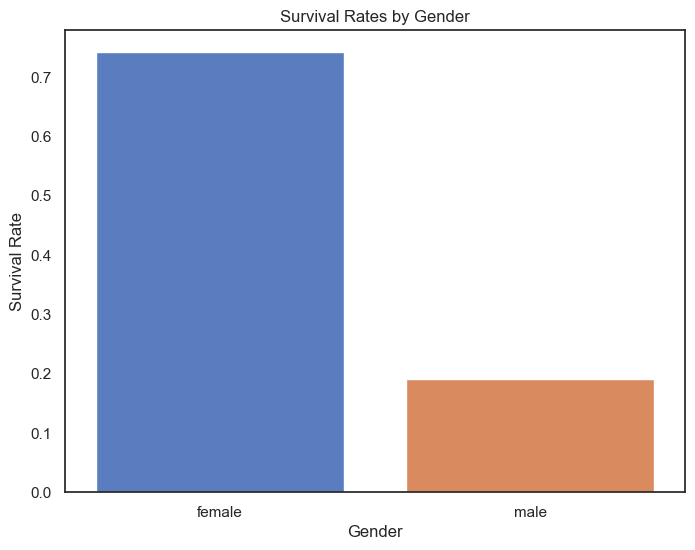

Sex
female    0.742038
male      0.190227
Name: Survived, dtype: float64
---- Code Ends ----


<string>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



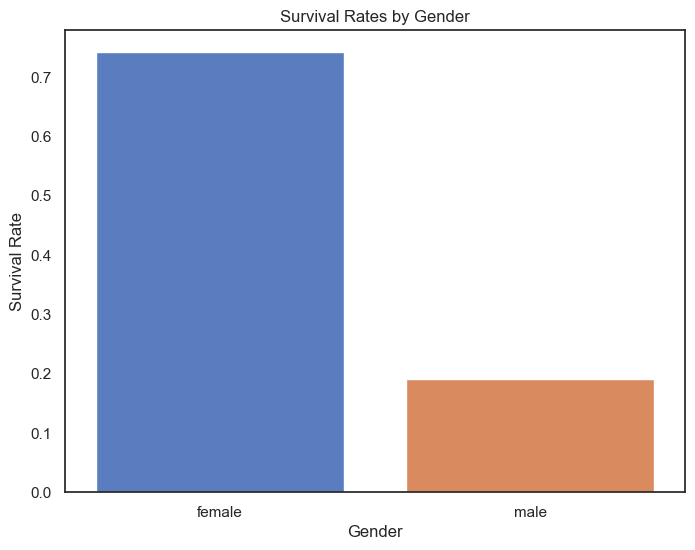

---- Message Begins ----
Sex
female    0.742038
male      0.190227
Name: Survived, dtype: float64
---- Message Ends ----
---- Final Answer Begins ----
The survival rate for women is approximately 74.2%, while for men it is about 19.0%. This indicates that women had a significantly higher survival rate compared to men.
---- Final Answer Ends ----


In [9]:
stream_response("What is the difference in survival rates between men and women?")

<string>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



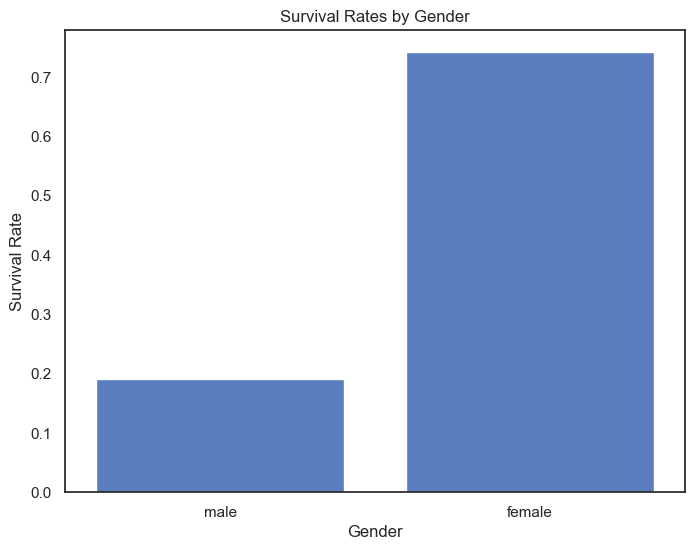

<string>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



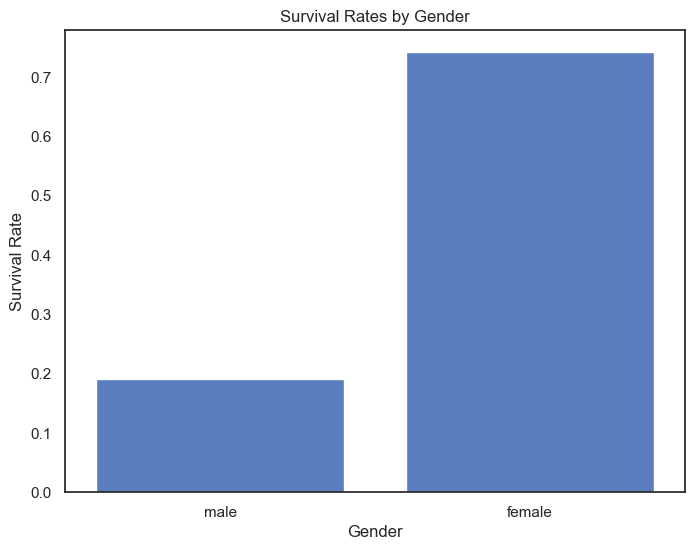

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Set visualization preferences
sns.set_theme(style="white", palette="muted")

# Create a barplot for survival rates by gender
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Sex", y="Survived", ci=None)
plt.title("Survival Rates by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Gender")
plt.show()

---- Code Ends ----
---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The barplot visualizing the survival rates of male and female passengers has been displayed. It shows the survival rate for each gender, with females generally having a higher survival rate than males.
---- Final Answer Ends ----


In [12]:
stream_response(
    "Visualize the survival rates of male and female passengers in a barplot."
)

<string>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



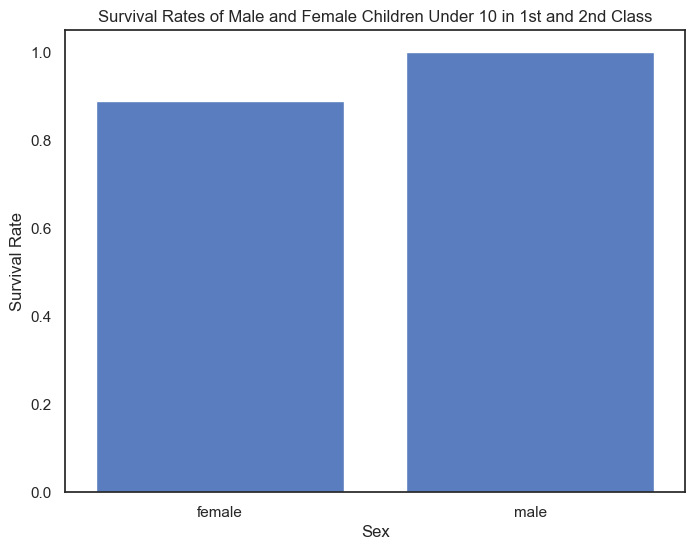

<string>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



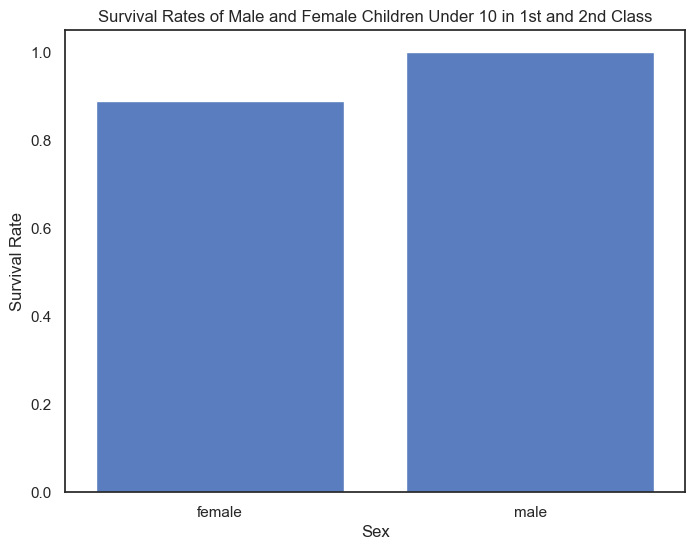

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for children under 10 in 1st and 2nd class
filtered_df = df[(df['Age'] < 10) & (df['Pclass'].isin([1, 2]))]

# Create a bar plot for survival rates by sex
plt.figure(figsize=(8, 6))
sns.set_theme(style="white", palette="muted")
sns.barplot(data=filtered_df, x='Sex', y='Survived', ci=None)
plt.title('Survival Rates of Male and Female Children Under 10 in 1st and 2nd Class')
plt.ylabel('Survival Rate')
plt.xlabel('Sex')
plt.show()

---- Code Ends ----
---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The visualization has been generated, showing the survival rates of male and female children under 10 in 1st and 2nd class. It uses a bar plot to compare survival rates by gender.
---- Final Answer Ends ----


In [13]:
stream_response(
    "Visualize the survival rates of male and female children under 10 in 1st and 2nd class."
)

In [10]:
stream_response(
    "what other visualization questions could I ask based on the contents of the CSV data file?."
)

---- Final Answer Begins ----
Based on the contents of the Titanic dataset, here are some visualization questions you could ask:

### Survival Analysis
1. **Survival Rate by Gender**: What is the survival rate for males and females?
2. **Survival Rate by Passenger Class**: How does survival rate vary across different passenger classes (Pclass)?
3. **Survival Rate by Age Group**: How does survival rate vary across different age groups (e.g., children, adults, elderly)?
4. **Survival Rate by Family Size**: Does having family aboard (siblings/spouses or parents/children) affect survival rate?

### Demographic Analysis
5. **Age Distribution**: What is the age distribution of passengers?
6. **Fare Distribution**: What is the distribution of fares paid by passengers?
7. **Gender Distribution**: What is the gender distribution of passengers across different classes?

### Correlation Analysis
8. **Fare vs. Survival**: Is there a correlation between the fare paid and survival rate?
9. **Age vs.

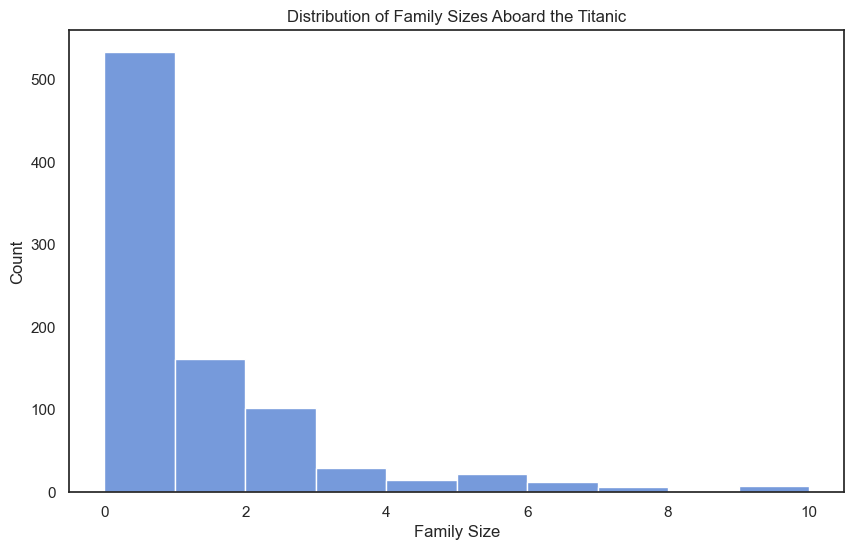

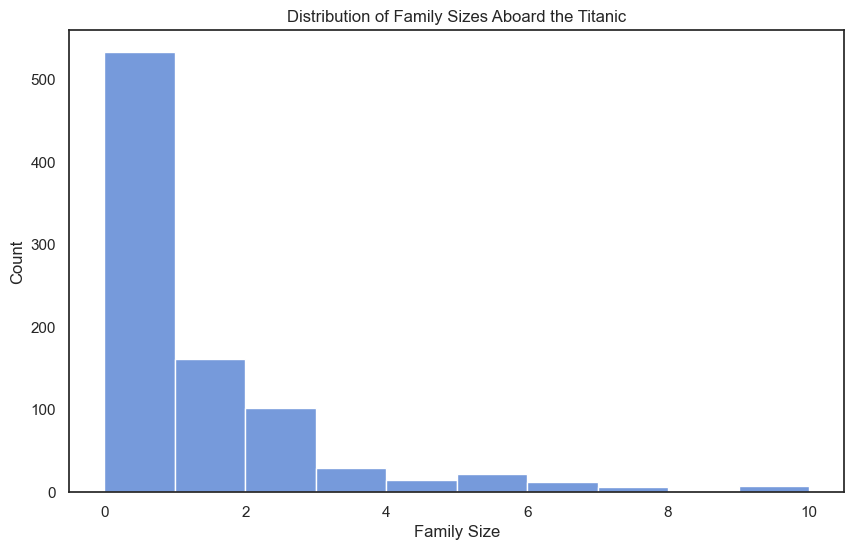

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate family size
family_size = df['Siblings/Spouses Aboard'] + df['Parents/Children Aboard']
df['Family Size'] = family_size

# Plot the distribution
sns.set_theme(style="white", palette="muted")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Family Size', kde=False, bins=10)
plt.title('Distribution of Family Sizes Aboard the Titanic')
plt.xlabel('Family Size')
plt.ylabel('Count')
plt.show()

---- Code Ends ----
---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The distribution of family sizes aboard the Titanic has been visualized using a histogram. The plot shows the count of passengers for each family size, ranging from individuals traveling alone to larger family groups.
---- Final Answer Ends ----


In [15]:
stream_response(
    "What is the distribution of family sizes aboard the Titanic?"
)